Deconvolution Microscopy (All Channels)
=======================================

This example partially replicates a [GlobalBioIm
example](https://biomedical-imaging-group.github.io/GlobalBioIm/examples.html)
using the [microscopy data](http://bigwww.epfl.ch/deconvolution/bio/)
provided by the EPFL Biomedical Imaging Group.

The deconvolution problem is solved using class
[admm.ADMM](../_autosummary/scico.optimize.rst#scico.optimize.ADMM) to
solve an image deconvolution problem with isotropic total variation (TV)
regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| M (\mathbf{y} - A \mathbf{x})
  \|_2^2 + \lambda \| C \mathbf{x} \|_{2,1} +
  \iota_{\mathrm{NN}}(\mathbf{x}) \;,$$

where $M$ is a mask operator, $A$ is circular convolution,
$\mathbf{y}$ is the blurred image, $C$ is a convolutional gradient
operator, $\iota_{\mathrm{NN}}$ is the indicator function of the
non-negativity constraint, and $\mathbf{x}$ is the desired image.

In [1]:
# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install git+https://github.com/lanl/scico
!pip install ray

# isort: off
import numpy as np

import logging
import ray

ray.init(logging_level=logging.ERROR)  # need to call init before jax import: ray-project/ray#44087

import scico.numpy as snp
from scico import functional, linop, loss, plot
from scico.examples import downsample_volume, epfl_deconv_data, tile_volume_slices
from scico.optimize.admm import ADMM, CircularConvolveSolver
plot.config_notebook_plotting()

Get and preprocess data. The data is downsampled to limit the memory
requirements and run time of the example. Reducing the downsampling rate
will make the example slower and more memory-intensive. To run this
example on a GPU it may be necessary to set environment variables
`XLA_PYTHON_CLIENT_ALLOCATOR=platform` and
`XLA_PYTHON_CLIENT_PREALLOCATE=false`. If your GPU does not have enough
memory, you can try setting the environment variable
`JAX_PLATFORM_NAME=cpu` to run on CPU.

In [2]:
downsampling_rate = 2

y_list = []
y_pad_list = []
psf_list = []
for channel in range(3):
    y, psf = epfl_deconv_data(channel, verbose=True)  # get data
    y = downsample_volume(y, downsampling_rate)  # downsample
    psf = downsample_volume(psf, downsampling_rate)
    y -= y.min()  # normalize y
    y /= y.max()
    psf /= psf.sum()  # normalize psf
    if channel == 0:
        padding = [[0, p] for p in snp.array(psf.shape) - 1]
        mask = snp.pad(snp.ones_like(y), padding)
    y_pad = snp.pad(y, padding)  # zero-padded version of y
    y_list.append(y)
    y_pad_list.append(y_pad)
    psf_list.append(psf)
y = snp.stack(y_list, axis=-1)
yshape = y.shape
del y_list

Define problem and algorithm parameters.

In [3]:
λ = 2e-6  # ℓ1 norm regularization parameter
ρ0 = 1e-3  # ADMM penalty parameter for first auxiliary variable
ρ1 = 1e-3  # ADMM penalty parameter for second auxiliary variable
ρ2 = 1e-3  # ADMM penalty parameter for third auxiliary variable
maxiter = 100  # number of ADMM iterations

Determine available computing resources, and put large arrays in ray
object store.

In [4]:
ngpu = 0
ar = ray.available_resources()
ncpu = max(int(ar["CPU"]) // 3, 1)
if "GPU" in ar:
    ngpu = int(ar["GPU"]) // 3
print(f"Running on {ncpu} CPUs and {ngpu} GPUs per process")

y_pad_list = ray.put(y_pad_list)
psf_list = ray.put(psf_list)
mask_store = ray.put(mask)

Running on 26 CPUs and 2 GPUs per process


Define ray remote function for parallel solves.

In [5]:
@ray.remote(num_cpus=ncpu, num_gpus=ngpu)
def deconvolve_channel(channel):
    """Deconvolve a single channel."""
    y_pad = ray.get(y_pad_list)[channel]
    psf = ray.get(psf_list)[channel]
    mask = ray.get(mask_store)
    M = linop.Diagonal(mask)
    C0 = linop.CircularConvolve(
        h=psf, input_shape=mask.shape, h_center=snp.array(psf.shape) / 2 - 0.5  # forward operator
    )
    C1 = linop.FiniteDifference(input_shape=mask.shape, circular=True)  # gradient operator
    C2 = linop.Identity(mask.shape)  # identity operator
    g0 = loss.SquaredL2Loss(y=y_pad, A=M)  # loss function (forward model)
    g1 = λ * functional.L21Norm()  # TV penalty (when applied to gradient)
    g2 = functional.NonNegativeIndicator()  # non-negativity constraint
    if channel == 0:
        print("Displaying solver status for channel 0")
        display = True
    else:
        display = False
    solver = ADMM(
        f=None,
        g_list=[g0, g1, g2],
        C_list=[C0, C1, C2],
        rho_list=[ρ0, ρ1, ρ2],
        maxiter=maxiter,
        itstat_options={"display": display, "period": 10, "overwrite": False},
        x0=y_pad,
        subproblem_solver=CircularConvolveSolver(),
    )
    x_pad = solver.solve()
    x = x_pad[: yshape[0], : yshape[1], : yshape[2]]
    return (x, solver.itstat_object.history(transpose=True))

Solve problems for all three channels in parallel and extract results.

In [6]:
ray_return = ray.get([deconvolve_channel.remote(channel) for channel in range(3)])
x = snp.stack([t[0] for t in ray_return], axis=-1)
solve_stats = [t[1] for t in ray_return]

(deconvolve_channel pid=524759) Displaying solver status for channel 0


(deconvolve_channel pid=524759) Iter  Time      Objective  Prml Rsdl  Dual Rsdl
(deconvolve_channel pid=524759) -----------------------------------------------
(deconvolve_channel pid=524759)    0  1.35e+01  2.830e-01  8.790e+00  1.948e-01


(deconvolve_channel pid=524759)   10  2.07e+01  1.033e+00  1.747e+00  1.200e-01


(deconvolve_channel pid=524759)   20  2.70e+01  1.158e+00  2.364e+00  5.443e-02


(deconvolve_channel pid=524759)   30  3.34e+01  1.297e+00  1.438e+00  6.374e-02


(deconvolve_channel pid=524759)   40  3.98e+01  1.528e+00  1.543e+00  4.295e-02


(deconvolve_channel pid=524759)   50  4.63e+01  1.733e+00  1.183e+00  4.423e-02


(deconvolve_channel pid=524759)   60  5.28e+01  1.919e+00  1.072e+00  3.910e-02


(deconvolve_channel pid=524759)   70  5.94e+01  2.133e+00  9.474e-01  3.361e-02


(deconvolve_channel pid=524759)   80  6.58e+01  2.341e+00  7.767e-01  3.187e-02


(deconvolve_channel pid=524759)   90  7.24e+01  2.560e+00  7.706e-01  2.754e-02


Show the recovered image.

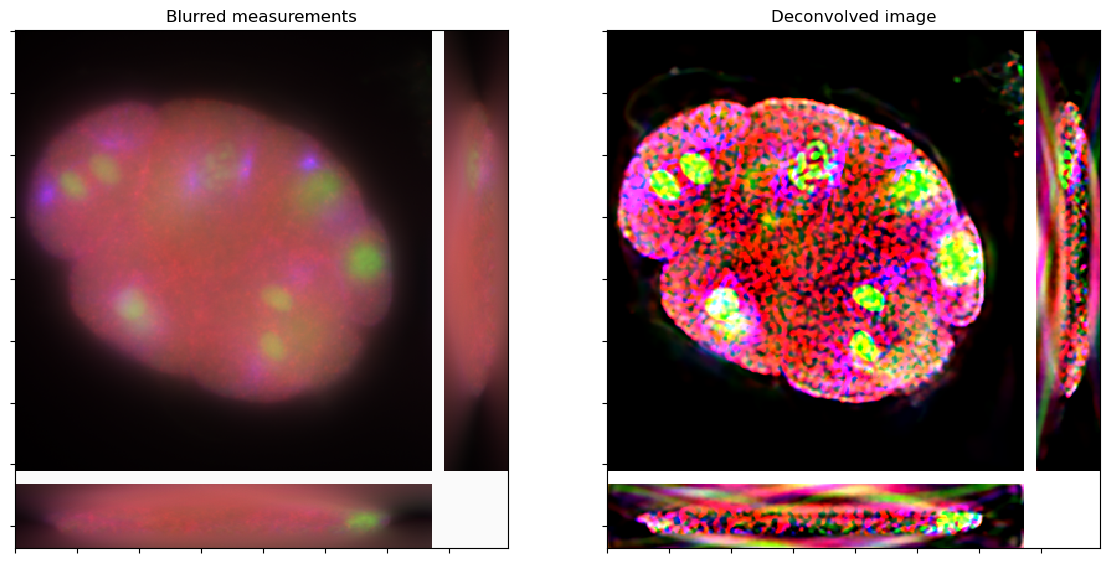

In [7]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot.imview(tile_volume_slices(y), title="Blurred measurements", fig=fig, ax=ax[0])
plot.imview(tile_volume_slices(x), title="Deconvolved image", fig=fig, ax=ax[1])
fig.show()

Plot convergence statistics.

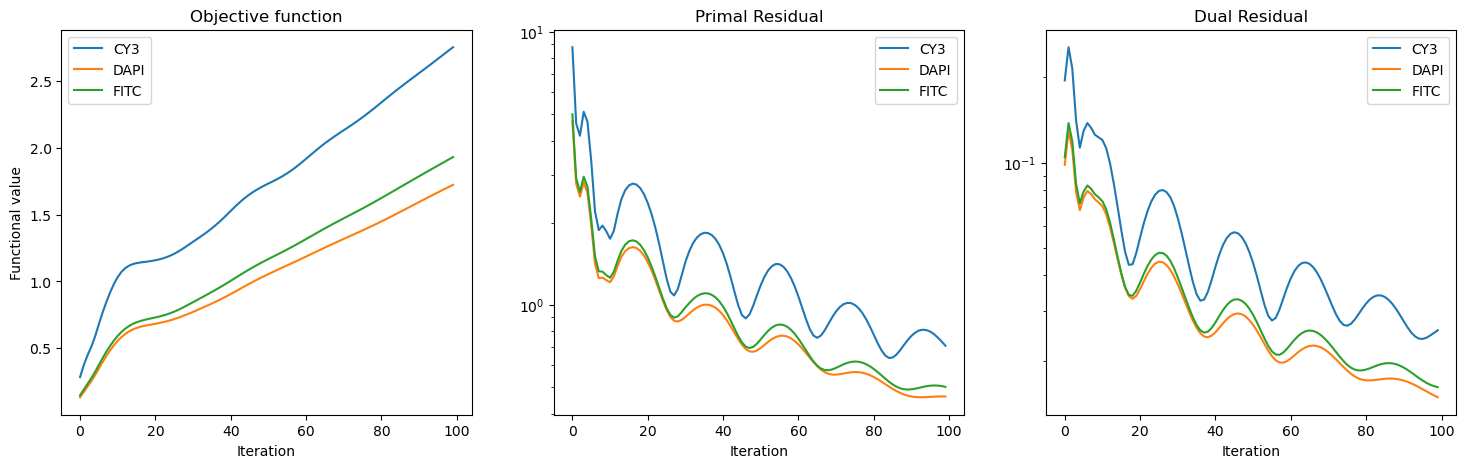

In [8]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(18, 5))
plot.plot(
    np.stack([s.Objective for s in solve_stats]).T,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    lgnd=("CY3", "DAPI", "FITC"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    np.stack([s.Prml_Rsdl for s in solve_stats]).T,
    ptyp="semilogy",
    title="Primal Residual",
    xlbl="Iteration",
    lgnd=("CY3", "DAPI", "FITC"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    np.stack([s.Dual_Rsdl for s in solve_stats]).T,
    ptyp="semilogy",
    title="Dual Residual",
    xlbl="Iteration",
    lgnd=("CY3", "DAPI", "FITC"),
    fig=fig,
    ax=ax[2],
)
fig.show()